# Demo
1. Show two json files as the inputs
2. Post to terrarium funman api, show response id
3. Get result from id, and plot

# Todo
1. How to interact with terrarium
2. Setup API for two json files
3. Setup async anytime results
4. Truncate/halt request endpoint
5. Allow multiple requests in a queue, needs server thread

# Demo Setup

In [1]:
# Common imports
import asyncio
import nest_asyncio
import os
import json
from pathlib import Path

from IPython.display import JSON

# Setup URLs
API_BASE_PATH = os.path.join(os.getcwd(), "..")
# Currently assumes a localhost server us running (see funman_server.ipynb)
API_SERVER_HOST = "127.0.0.1"
API_SERVER_PORT = 8190
SERVER_URL = f"http://{API_SERVER_HOST}:{API_SERVER_PORT}"
OPENAPI_URL = f"{SERVER_URL}/openapi.json"
CLIENT_NAME = "funman-api-client"

# Setup Paths
RESOURCES = Path("../resources").resolve()
# example paths
EXAMPLE_DIR = RESOURCES / "funman" / "infected_threshold_example"
MODEL_PATH = EXAMPLE_DIR / "model.json"
REQUEST_PATH = EXAMPLE_DIR / "request.json"

In [2]:
# Alternative example
EXAMPLE_DIR = RESOURCES / "common_model" / "petrinet"
MODEL_PATH = EXAMPLE_DIR / "sir.json"
REQUEST_PATH = EXAMPLE_DIR / "request.json"

In [3]:
# Install API client to the working directory
# and add the install to the sys path
import funman.api.client as client
client.make_client(
    API_BASE_PATH, openapi_url=OPENAPI_URL, client_name=CLIENT_NAME
)
nest_asyncio.apply()

Updating existing funman client at /home/danbryce/funman from http://127.0.0.1:8190/openapi.json
Updating funman_api_client


# Import and initialize the FUNMAN API Client

In [4]:
# Setup API client request
from funman_api_client import Client
from funman_api_client.api.default import (
    post_queries_queries_post,
    get_queries_queries_query_id_get,
)
from funman_api_client.models.body_post_queries_queries_post import BodyPostQueriesQueriesPost
from funman_api_client.models import (
    BilayerModel,
    FUNMANConfig,
    LabeledParameter,
    QueryLE,
    FunmanWorkRequest,
    FunmanWorkUnit,
    FunmanResults,
    QueryTrue,
    GeneratedPetriNetModel
    
)

# Create a funman client
funman_client = Client(SERVER_URL, timeout=None)

ImportError: cannot import name 'post_queries_queries_post' from 'funman_api_client.api.default' (/home/danbryce/funman/funman-api-client/funman_api_client/api/default/__init__.py)

# Read in the input files

In [5]:
# Read in the model file
model = json.loads(MODEL_PATH.read_bytes())
# pretty print
print(json.dumps(model, indent=2))

{
  "name": "SIR Model",
  "schema": "https://raw.githubusercontent.com/DARPA-ASKEM/Model-Representations/petrinet_v0.1/petrinet/petrinet_schema.json",
  "schema_name": "petrinet",
  "description": "SIR model created by Ben, Micah, Brandon",
  "model_version": "0.1",
  "model": {
    "states": [
      {
        "id": "S",
        "name": "Susceptible",
        "description": "Number of individuals that are 'susceptible' to a disease infection",
        "grounding": {
          "identifiers": {
            "ido": "0000514"
          }
        },
        "units": {
          "expression": "person",
          "expression_mathml": "<ci>person</ci>"
        }
      },
      {
        "id": "I",
        "name": "Infected",
        "description": "Number of individuals that are 'infected' by a disease",
        "grounding": {
          "identifiers": {
            "ido": "0000511"
          }
        },
        "units": {
          "expression": "person",
          "expression_mathml": "<ci>p

In [6]:
# Read in the funman request file
request = json.loads(REQUEST_PATH.read_bytes())
# pretty print
print(json.dumps(request, indent=2))

{
  "query": {},
  "parameters": [
    {
      "name": "beta",
      "lb": 2.6e-07,
      "ub": 2.8e-07,
      "label": "any"
    },
    {
      "name": "gamma",
      "lb": 0.1,
      "ub": 0.18,
      "label": "any"
    },
    {
      "name": "S0",
      "lb": 1000,
      "ub": 1000,
      "label": "any"
    },
    {
      "name": "I0",
      "lb": 1,
      "ub": 1,
      "label": "any"
    },
    {
      "name": "R0",
      "lb": 0,
      "ub": 0,
      "label": "any"
    }
  ],
  "config": {
    "tolerance": 1e-08,
    "number_of_processes": 1,
    "save_smtlib": true
  }
}


# Make a request

In [7]:
# Make a POST request to the API endpoint
response = asyncio.run(
    post_queries_queries_post.asyncio_detailed(
        client=funman_client,
        json_body=BodyPostQueriesQueriesPost.from_dict({
            "model": model,
            "request": request
        }),
    )
)

# The response returns a work unit
work_unit = FunmanWorkUnit.from_dict(
    src_dict=json.loads(response.content.decode())
)
# Where the id can be used to pull ongoing results
work_unit.id

ConnectError: All connection attempts failed

# Request results

In [ ]:
# Make a GET request to the API endpoint
response = asyncio.run(get_queries_queries_query_id_get.asyncio_detailed(
    work_unit.id,
    client=funman_client
))
# The response returns the latest funman results for the query
results = FunmanResults.from_dict(
    src_dict=json.loads(response.content.decode())
)
# pretty print the parameter_space
print(json.dumps(results.parameter_space.to_dict(), indent=2))

{
  "true_boxes": [],
  "false_boxes": [],
  "true_points": [
    {
      "values": {},
      "type": "point",
      "label": "true"
    }
  ],
  "false_points": []
}


# Plot

show


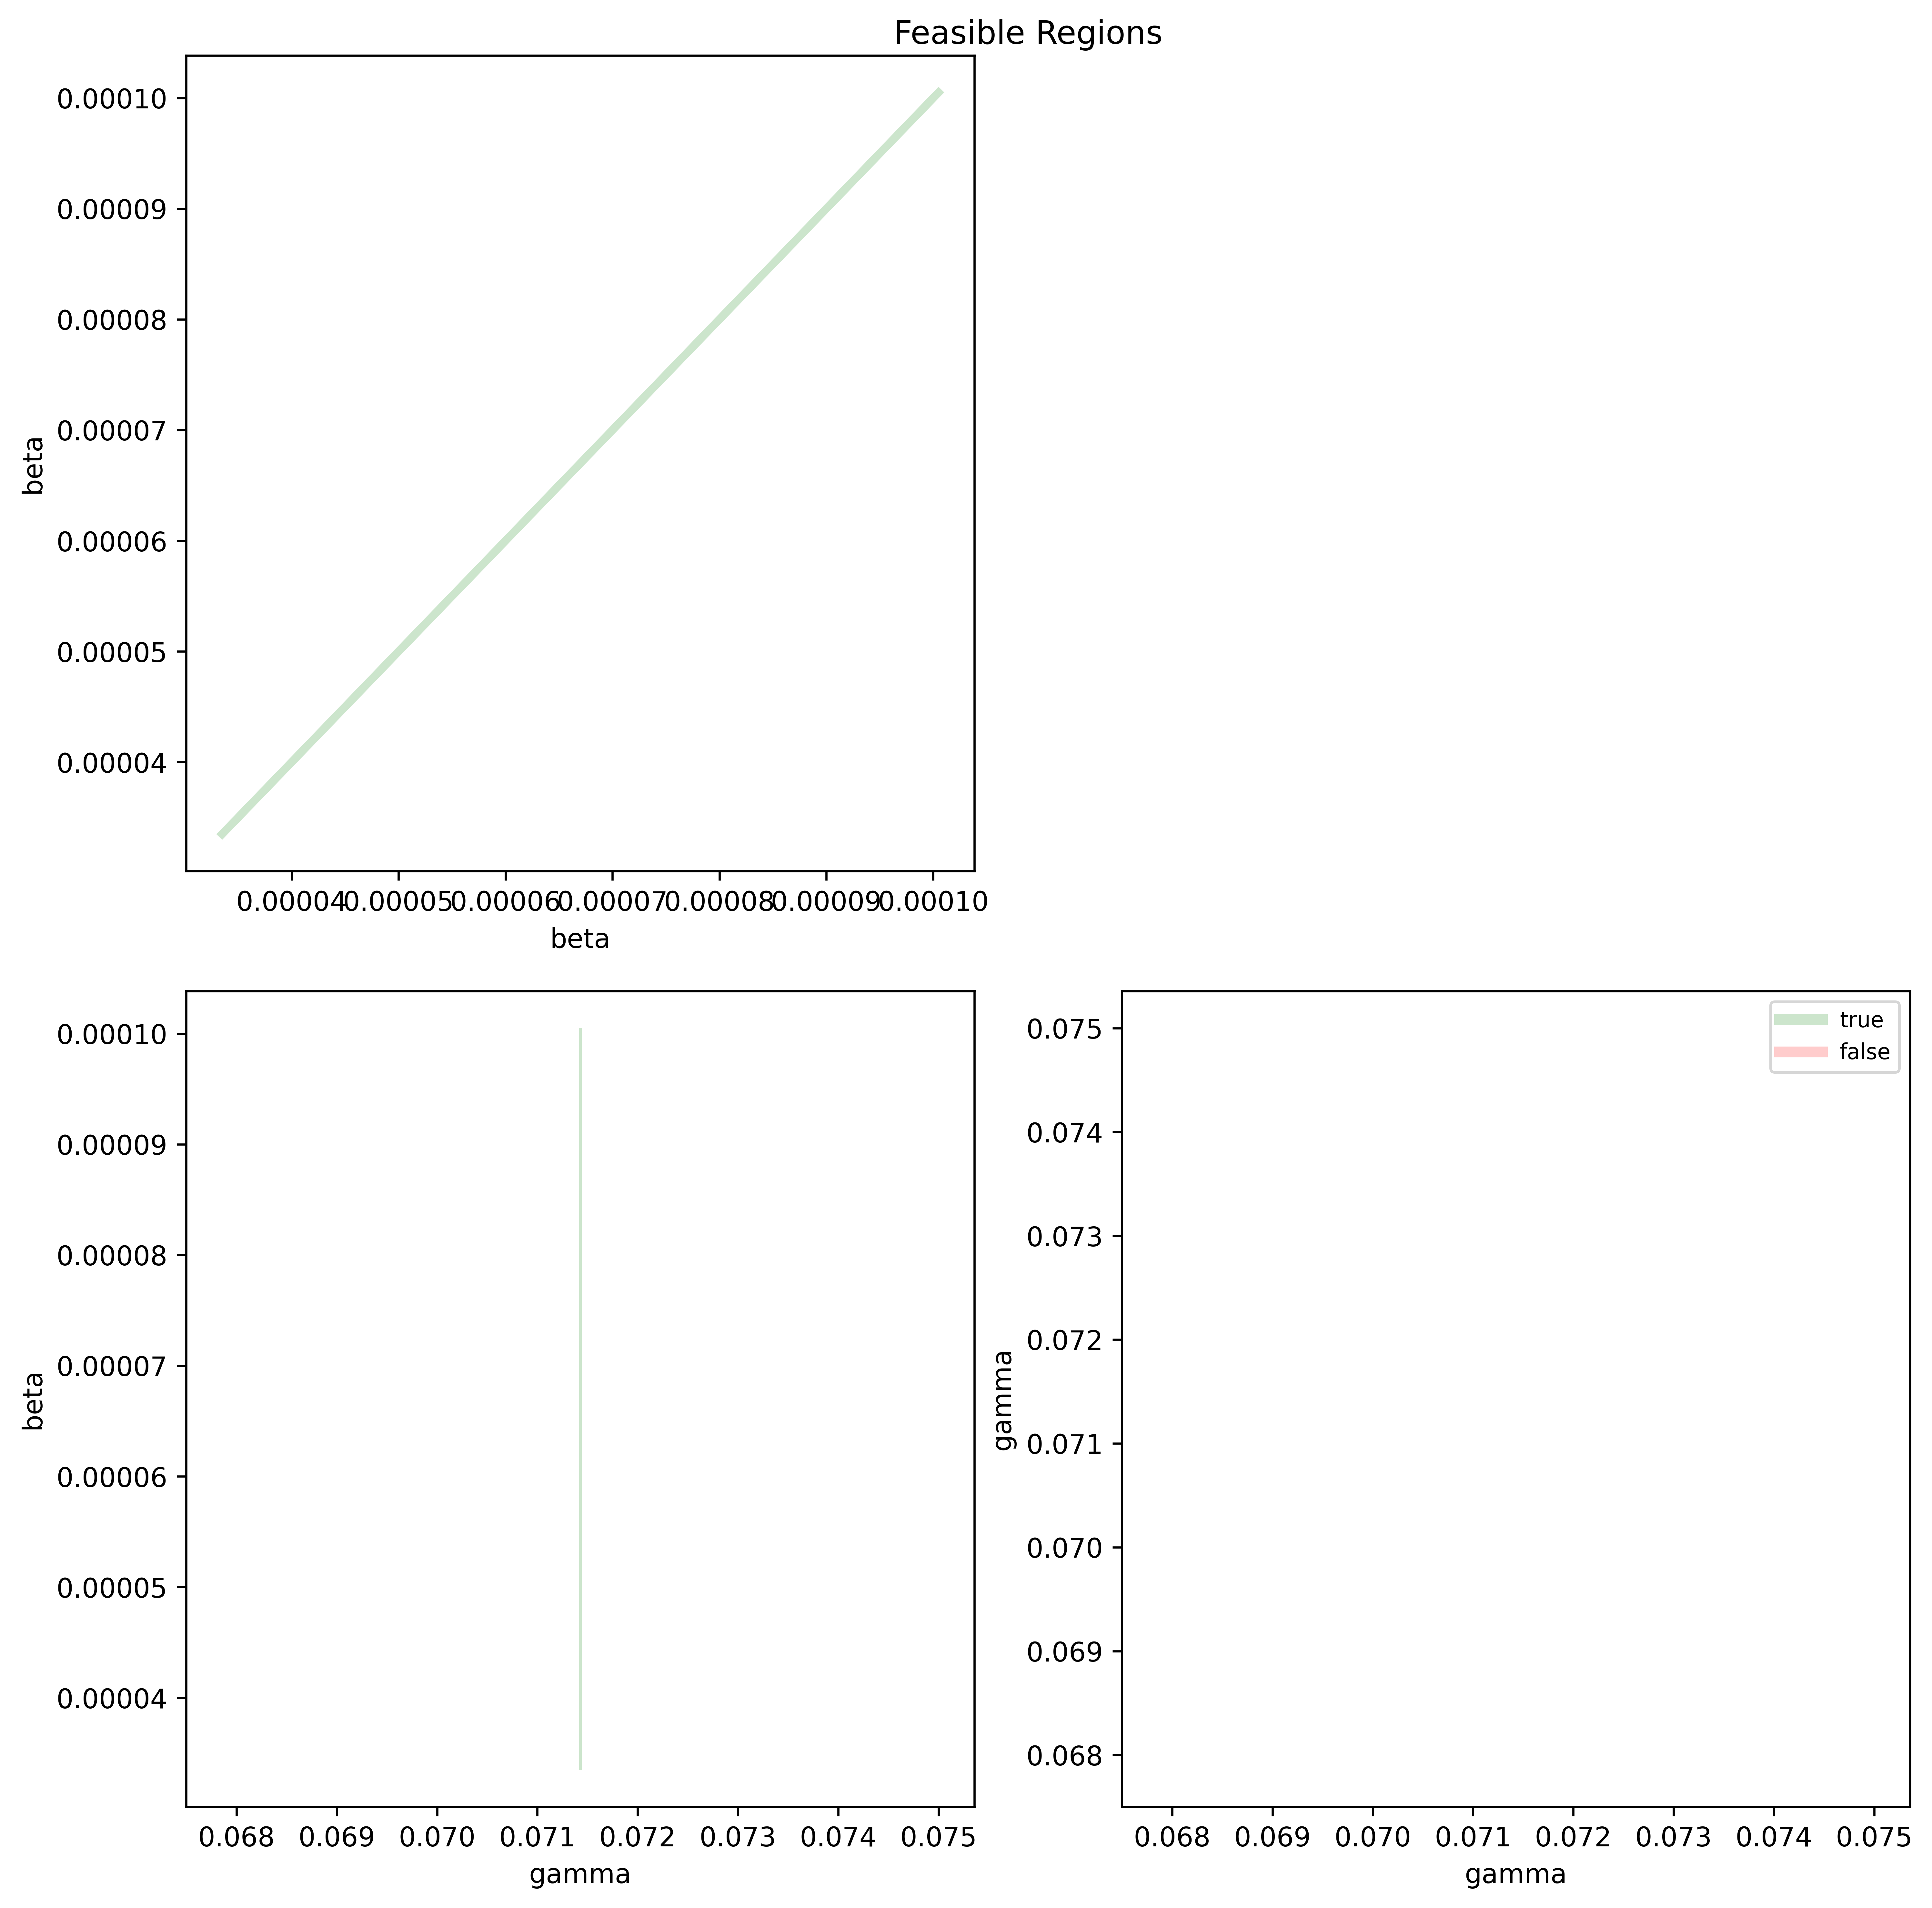

In [ ]:
# Plot the ParameterSpace
from funman_demo.parameter_space_plotter import ParameterSpacePlotter
ParameterSpacePlotter(results.parameter_space).plot(show=True)